In [33]:
import os
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"


In [34]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline


In [35]:
# Load preprocessed dataset
df = pd.read_csv("data/cleaned_diabetes_data.csv")
print("✅ Cleaned dataset loaded:", df.shape)
print("Target distribution:\n", df["diabetes"].value_counts(normalize=True))


✅ Cleaned dataset loaded: (100000, 19)
Target distribution:
 diabetes
0    0.915
1    0.085
Name: proportion, dtype: float64


In [36]:
X = df.drop(columns=['diabetes'])
y = df['diabetes']


In [37]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)


In [38]:
# Define samplers
samplers = {
    "Original": None,  # no resampling
    "Undersample": RandomUnderSampler(random_state=42),
    "SMOTE": SMOTE(random_state=42)
}
#Models, KNN and logistic regression
models = {
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "LogReg": LogisticRegression(max_iter=2000, random_state=42)  # lbfgs default, OK
}
results=[]

In [39]:
results_original = []

for model_name, model in {
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "LogReg": LogisticRegression(max_iter=2000, random_state=42)
}.items():

    pipe = Pipeline(steps=[
        ("scaler", StandardScaler()),
        ("model", model)
    ])

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    rep = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    bal_acc = balanced_accuracy_score(y_test, y_pred)

    results_original.append({
        "Model": model_name,
        "Precision_pos": rep["1"]["precision"],
        "Recall_pos": rep["1"]["recall"],
        "F1_pos": rep["1"]["f1-score"],
        "Balanced_Acc": bal_acc
    })

df_original = pd.DataFrame(results_original)
print("=== Original Data Results ===")
print(df_original)


=== Original Data Results ===
    Model  Precision_pos  Recall_pos    F1_pos  Balanced_Acc
0     KNN       0.884250    0.548235  0.676834      0.770784
1  LogReg       0.866079    0.635294  0.732949      0.813084


In [40]:
# UNDERSAMPLING

results_under = []

for model_name, model in {
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "LogReg": LogisticRegression(max_iter=2000, random_state=42)
}.items():

    pipe = ImbPipeline(steps=[
        ("scaler", StandardScaler()),
        ("undersample", RandomUnderSampler(random_state=42)),
        ("model", model)
    ])

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    rep = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    bal_acc = balanced_accuracy_score(y_test, y_pred)

    results_under.append({
        "Model": model_name,
        "Precision_pos": rep["1"]["precision"],
        "Recall_pos": rep["1"]["recall"],
        "F1_pos": rep["1"]["f1-score"],
        "Balanced_Acc": bal_acc
    })

df_under = pd.DataFrame(results_under)
print("=== Undersampling Results ===")
print(df_under)


=== Undersampling Results ===
    Model  Precision_pos  Recall_pos    F1_pos  Balanced_Acc
0     KNN       0.340799    0.868235  0.489471      0.856112
1  LogReg       0.418430    0.884118  0.568027      0.884982


In [41]:
# SMOTE OVERSAMPLING

## Visualize how the dataset changes with SMOTE
X_res, y_res = SMOTE(random_state=42).fit_resample(X_train, y_train)
print("After SMOTE:", Counter(y_res))

results_smote = []

for model_name, model in {
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "LogReg": LogisticRegression(max_iter=2000, random_state=42)
}.items():

    pipe = ImbPipeline(steps=[
        ("scaler", StandardScaler()),
        ("smote", SMOTE(random_state=42)),
        ("model", model)
    ])

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    rep = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    bal_acc = balanced_accuracy_score(y_test, y_pred)

    results_smote.append({
        "Model": model_name,
        "Precision_pos": rep["1"]["precision"],
        "Recall_pos": rep["1"]["recall"],
        "F1_pos": rep["1"]["f1-score"],
        "Balanced_Acc": bal_acc
    })

df_smote = pd.DataFrame(results_smote)
print("=== SMOTE Results ===")
print(df_smote)


After SMOTE: Counter({1: 73200, 0: 73200})
=== SMOTE Results ===
    Model  Precision_pos  Recall_pos    F1_pos  Balanced_Acc
0     KNN       0.452341    0.790000  0.575284      0.850574
1  LogReg       0.424936    0.874118  0.571868      0.882113


In [42]:
final_results = pd.concat([
    df_original.assign(Resampling="Original"),
    df_under.assign(Resampling="Undersample"),
    df_smote.assign(Resampling="SMOTE")
], ignore_index=True)

print("\n=== Combined Results Summary ===")
print(final_results)


=== Combined Results Summary ===
    Model  Precision_pos  Recall_pos    F1_pos  Balanced_Acc   Resampling
0     KNN       0.884250    0.548235  0.676834      0.770784     Original
1  LogReg       0.866079    0.635294  0.732949      0.813084     Original
2     KNN       0.340799    0.868235  0.489471      0.856112  Undersample
3  LogReg       0.418430    0.884118  0.568027      0.884982  Undersample
4     KNN       0.452341    0.790000  0.575284      0.850574        SMOTE
5  LogReg       0.424936    0.874118  0.571868      0.882113        SMOTE


In [43]:
##Visualize what changed
from collections import Counter
print("Before resampling:", Counter(y_train))
X_res, y_res = RandomUnderSampler(random_state=42).fit_resample(X_train, y_train)
print("After undersampling:", Counter(y_res))


Before resampling: Counter({0: 73200, 1: 6800})
After undersampling: Counter({0: 6800, 1: 6800})


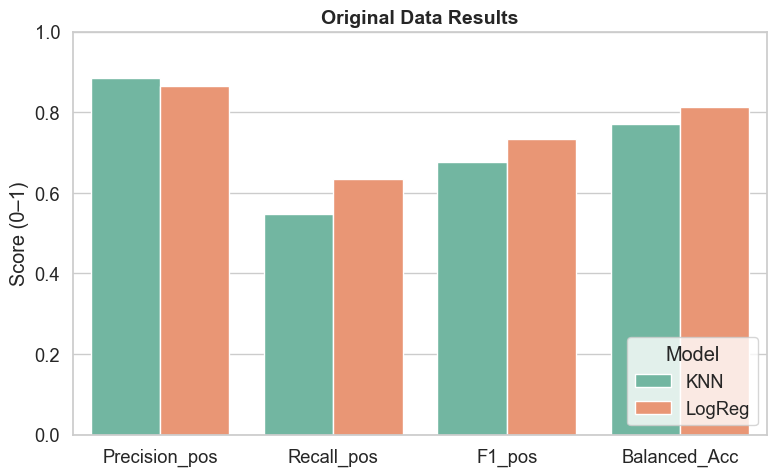

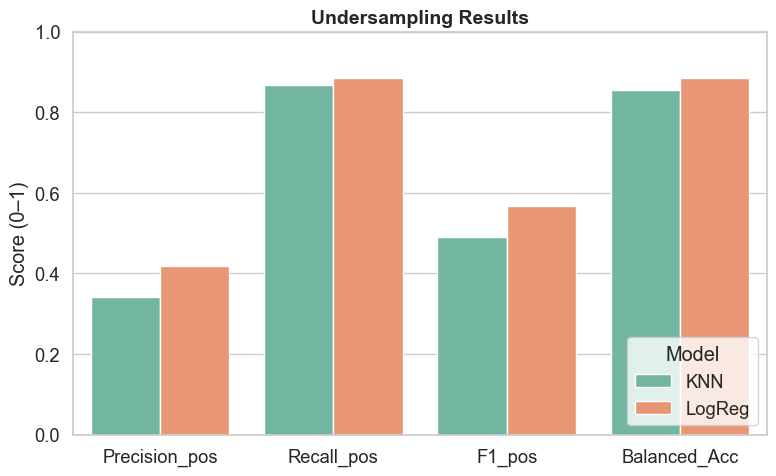

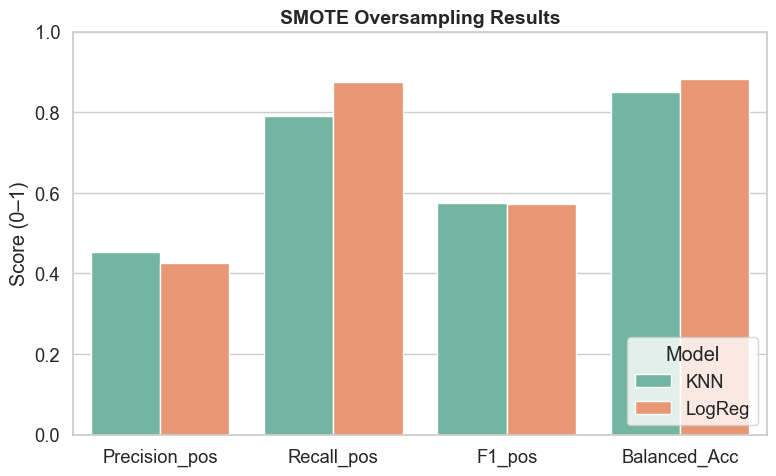

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: for better plot style
sns.set(style="whitegrid", font_scale=1.2)

def plot_results(df, title):
    """
    Create a bar chart for each resampling method.
    df: dataframe with columns ["Model", "Precision_pos", "Recall_pos", "F1_pos", "Balanced_Acc"]
    """
    # Melt dataframe for plotting (long format)
    df_long = df.melt(id_vars="Model",
                      value_vars=["Precision_pos", "Recall_pos", "F1_pos", "Balanced_Acc"],
                      var_name="Metric", value_name="Score")

    plt.figure(figsize=(8,5))
    sns.barplot(data=df_long, x="Metric", y="Score", hue="Model", palette="Set2")

    plt.title(title, fontsize=14, weight="bold")
    plt.ylabel("Score (0–1)")
    plt.ylim(0, 1)
    plt.xlabel("")
    plt.legend(title="Model", loc="lower right")
    plt.tight_layout()
    plt.show()


# Plot results for each scenario
plot_results(df_original, "Original Data Results")
plot_results(df_under, "Undersampling Results")
plot_results(df_smote, "SMOTE Oversampling Results")
